In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [101]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

In [102]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 29 14:14:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080    On   | 00000000:09:00.0 Off |                  N/A |
|  0%   31C    P8     2W / 110W |    484MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
vmem = virtual_memory()

print('Total {:.2f} gigabytes RAM\n'.format(virtual_memory().total / 1e9))
print('available {:.2f} gigabytes RAM\n'.format(virtual_memory().available / 1e9))
print('free {:.2f} gigabytes RAM\n'.format(virtual_memory().free / 1e9))

Total 202.74 gigabytes RAM

available 125.03 gigabytes RAM

free 80.02 gigabytes RAM



# Imports

In [7]:
import os
import sys
import gc
import random
import datetime
import pickle
import logging
import typing as T
from typing import (
    List, Optional,
    Union, Tuple
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

import tensorflow.keras.layers as L
import tensorflow_addons as tfa

In [10]:
tf.__version__

'2.4.1'

# Methods

In [11]:
def save_pickle(a, filepath):
    with open(filepath, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
def load_pickle(filepath):
    with open(filepath, 'rb') as handle:
        b = pickle.load(handle)
        
    return b

In [12]:
def get_full_dataset(
    data_path: str,
    part_names: T.List[str],
    columns: T.Optional[T.List[str]] = None
    ) -> pd.DataFrame:
    df = pd.DataFrame(columns=columns)
    for part in tqdm(part_names):
        dft = load_pickle(os.path.join(data_path, part))
        if columns:
            dft = dft[columns]
        df = pd.concat((df, dft))
        del dft
        collected_gc = gc.collect()
        logger.info(f"Partition read: {part}; gc.collect: {collected_gc}")
    return df.reset_index(drop=True)

In [13]:
def show_df_memory_usage_gb(df: pd.DataFrame): 
    memory_usage = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'RAM memory usage: {round(memory_usage, 4)} Gb')

# Settings

In [21]:
PROJ_PATH = ".."
DATA_PATH = os.path.join(PROJ_PATH, "data")
MODELS_PATH = os.path.join(PROJ_PATH, 'models')

PREPROCESSED_DATA_PATH = os.path.join(DATA_PATH, "preprocessed")
SEQ_DATA_PATH = os.path.join(PREPROCESSED_DATA_PATH, "sequence", "train")
SEQ_TEST_DATA_PATH = os.path.join(PREPROCESSED_DATA_PATH, "sequence", "test")



In [16]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [17]:
SEED = 42
seed_everything(seed=SEED)

In [19]:
y_column = 'multi_class_target'

In [20]:
logger = logging.getLogger(name=__name__)
logging.basicConfig(format = u'%(filename)s[LINE:%(lineno)d] # [%(levelname)-8s] [%(asctime)s]  %(message)s', level = logging.INFO)


# Get data

In [22]:
part_names = [
"preprocessed_df_april.pickle",
"preprocessed_df_july.pickle",
"preprocessed_df_sep.pickle",
                ]

In [23]:
cols = ['session_id', 'timestamp', 'client',
       'multi_class_target', 'prev_time_diffs_token',
       'prev_sess_length_seconds_token', 'prev_target_token', 'prev_net_token',
       'prev_event_type_seq_token', 'prev_event_category_seq_token',
       'prev_event_device_screen_name_seq_token']

In [26]:
df = get_full_dataset(
    data_path=SEQ_DATA_PATH, part_names=part_names, columns=cols
)
df.shape

<ipython-input-12-53a93e6578b2>[LINE:14] # [INFO    ] [2021-01-29 13:29:51,841]  Partition read: preprocessed_df_april.pickle; gc.collect: 0
<ipython-input-12-53a93e6578b2>[LINE:14] # [INFO    ] [2021-01-29 13:34:06,183]  Partition read: preprocessed_df_july.pickle; gc.collect: 0
<ipython-input-12-53a93e6578b2>[LINE:14] # [INFO    ] [2021-01-29 13:38:03,138]  Partition read: preprocessed_df_sep.pickle; gc.collect: 0


In [29]:
df = df.sort_values(by=['client', 'timestamp']).reset_index(drop=True)
df_train = df

## Test data

In [31]:
df_test = load_pickle(os.path.join(SEQ_TEST_DATA_PATH, 'df_test.pickle'))
df_test.shape

# Get columns

In [40]:
train_data = {
    "event_types": np.vstack(df_train['prev_event_type_seq_token']).reshape(-1, 60, 10),
    "event_categories": np.vstack(df_train['prev_event_category_seq_token']).reshape(-1, 60, 10),
    "screens": np.vstack(df_train['prev_event_device_screen_name_seq_token']).reshape(-1, 60, 10),
    "targets": np.vstack(df_train['prev_target_token']),
    "lengths": np.vstack(df_train['prev_sess_length_seconds_token']),
    "time_diffs": np.vstack(df_train['prev_time_diffs_token']),
    "nets": np.vstack(df_train['prev_net_token'])
}

In [42]:
test_data = {
    "event_types": np.vstack(df_test['prev_event_type_seq_token']).reshape(-1, 60, 10),
    "event_categories": np.vstack(df_test['prev_event_category_seq_token']).reshape(-1, 60, 10),
    "screens": np.vstack(df_test['prev_event_device_screen_name_seq_token']).reshape(-1, 60, 10),
    "targets": np.vstack(df_test['prev_target_token']),
    "lengths": np.vstack(df_test['prev_sess_length_seconds_token']),
    "time_diffs": np.vstack(df_test['prev_time_diffs_token']),
    "nets": np.vstack(df_test['prev_net_token'])
}

## Target

In [43]:
y_train = np.array(df_train[y_column])

# Preprocess labels

In [45]:
label_encoders = load_pickle(
    os.path.join(
        PREPROCESSED_DATA_PATH, "mappers", "label_encoders_from_pop_vals_50k.pickle"
        )
    )

In [44]:
label_list = list(np.unique(y_train))
label_map = {label: i for i, label in enumerate(label_list)}
reverse_label_map = {i: label for label, i in label_map.items()}
print(reverse_label_map)
label_map_func = lambda label: label_map[label]

y_train = np.array(list(map(label_map_func, y_train)))

y_train_ohe = tf.keras.utils.to_categorical(y_train)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 8, 8: 9, 9: 10}


In [47]:
y_test_true = label_encoders['multi_class_target'].transform(df_test['target'])
y_tst = np.array(list(map(label_map_func, y_test_true)))
y_test_ohe = tf.keras.utils.to_categorical(y_tst)

# Model

## Time embedding

In [48]:
class TimeEmbedding(L.Layer):
    def __init__(self, hidden_embedding_size, output_dim, **kwargs):
        super(TimeEmbedding, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.hidden_embedding_size = hidden_embedding_size


    def build(self, input_shape):
        self.emb_weights = self.add_weight(name='weights', shape=(self.hidden_embedding_size,), initializer='uniform',
                                           trainable=True)
        self.emb_biases = self.add_weight(name='biases', shape=(self.hidden_embedding_size,), initializer='uniform',
                                          trainable=True)
        self.emb_final = self.add_weight(name='embedding_matrix', shape=(self.hidden_embedding_size, self.output_dim),
                                         initializer='uniform', trainable=True)


    def call(self, x):
        x = tf.keras.backend.expand_dims(x)
        x = tf.keras.activations.softmax(x * self.emb_weights + self.emb_biases)
        x = tf.einsum('bsv,vi->bsi', x, self.emb_final)
        return x


    def get_config(self):
        config = super(TimeEmbedding, self).get_config()
        config.update({'time_dims': self.output_dim, 'hidden_embedding_size': self.hidden_embedding_size})
        return config


## Basic embedding

In [50]:
class BasicEmbedding(L.Layer):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        embedding_matrix: np.ndarray = None,
        is_embedding_trainable: bool = False,
        **kwargs
    ):
        super(BasicEmbedding, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embedding_matrix = embedding_matrix
        self.is_embedding_trainable = is_embedding_trainable


    def build(self, input_shape):
        input_length = input_shape[-1]
        if self.embedding_matrix is None:
            self.embedding = L.Embedding(
                input_dim=self.vocab_size,
                output_dim=self.embed_size,
                input_length=input_length
            )
        else:
            self.embedding = L.Embedding(
                input_dim=self.vocab_size,
                output_dim=self.embed_size,
                weights=[self.embedding_matrix],
                mask_zero=False,
                trainable=self.is_embedding_trainable,
                input_length=input_length
            )
        


    def call(self, input_tensor, training=False):
        x = self.embedding(input_tensor, training=training)
        return x


## Event embedding

In [52]:
class EventEmbedding(BasicEmbedding):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        embedding_matrix: np.ndarray = None,
        is_embedding_trainable: bool = False,
        **kwargs
    ):
        super(EventEmbedding, self).__init__(
            vocab_size,
            embed_size,
            embedding_matrix,
            is_embedding_trainable,
            **kwargs
        )    


    def call(self, input_tensor, training=False):
        x = self.embedding(input_tensor, training=training)
        # x = tf.reduce_mean(x, axis=2)
        # x = tf.concat(x, axis=2)
        concat_shape = [-1] + [x.shape[1]] + [x.shape[2]*x.shape[3]]
        x = tf.reshape(x, concat_shape)
        return x


## Embeddings class

In [70]:
class ContextSessionEmbeddings(L.Layer):
    def __init__(
        self,
        event_type_vocab_size: int,
        event_category_vocab_size: int,
        screens_vocab_size: int,
        target_vocab_size: int,
        net_vocab_size: int,
        time_projection_size: int,
        embed_size: int,
        reduced_embed_size: int,
        dropout_rate: float = 0.2,
        layer_norm_eps: float = 1e-12,
        **kwargs
    ):
        super(ContextSessionEmbeddings, self).__init__(**kwargs)
        
        # events
        self.event_type_embedding = EventEmbedding(
            vocab_size=event_type_vocab_size,
            embed_size=embed_size,
            embedding_matrix=None,
            is_embedding_trainable=True
        )
        self.event_category_embedding = EventEmbedding(
            vocab_size=event_category_vocab_size,
            embed_size=embed_size,
            embedding_matrix=None,
            is_embedding_trainable=True
        )
        self.screen_embedding = EventEmbedding(
            vocab_size=screens_vocab_size,
            embed_size=embed_size,
            embedding_matrix=None,
            is_embedding_trainable=True
        )
        
        
        # aka texts
        self.target_embedding = BasicEmbedding(
            vocab_size=target_vocab_size,
            embed_size=embed_size,
            embedding_matrix=None,
            is_embedding_trainable=True
        )
        self.net_embedding = BasicEmbedding(
            vocab_size=net_vocab_size,
            embed_size=embed_size,
            embedding_matrix=None,
            is_embedding_trainable=True
        )
        
        
        # Time
        self.time_diff_embedding = TimeEmbedding(
            hidden_embedding_size=time_projection_size,
            output_dim=embed_size
        )
        self.time_embedding = TimeEmbedding(
            hidden_embedding_size=time_projection_size,
            output_dim=embed_size
        )
        
        
        # Projection
        self.dense_reduction = L.Dense(reduced_embed_size, activation='linear')
        self.layer_norm = L.LayerNormalization(epsilon=layer_norm_eps)
        self.embed_dropout = L.Dropout(dropout_rate)
        

    def call(self, input_dict, training=False):
        ## get cols
        
        # events
        event_types = input_dict["event_types"]
        event_categories = input_dict["event_categories"]
        screens = input_dict["screens"]
        
        # texts
        targets = input_dict["targets"]
        nets = input_dict["nets"]
        
        # nums
        lengths = input_dict["lengths"]
        time_diffs = input_dict["time_diffs"]
        
        
        ## Get tensors
        # lists
        event_type_embs = self.event_type_embedding(event_types, training=training)
        event_category_embs = self.event_category_embedding(event_categories, training=training)
        screen_embs = self.screen_embedding(screens, training=training)

        # texts
        target_embs = self.target_embedding(targets, training=training)
        net_embs = self.net_embedding(nets, training=training)
        
        # nums
        time_embs = self.time_embedding(lengths, training=training)
        time_diff_embs = self.time_diff_embedding(time_diffs, training=training)
        
        
        ## concat
        embs = tf.concat([
                          event_type_embs, event_category_embs, screen_embs,
                            target_embs, net_embs, time_embs,
                          time_diff_embs
                          ], axis=2)
        
        ## project
        x = self.dense_reduction(embs, training=training)
        x = self.layer_norm(x, training=training)
        x = self.embed_dropout(x, training=training)
        
        return x

## ContextSessionLstmAvg model

In [71]:
class ContextSessionLstmAvg(tf.keras.Model):
    def __init__(
        self,
        event_type_vocab_size: int,
        event_category_vocab_size: int,
        screens_vocab_size: int,
        target_vocab_size: int,
        net_vocab_size: int,
        time_projection_size: int,
        embed_size: int,
        reduced_embed_size: int,
        output_size: int,
        lstm_units: int,
        dense_units: int,
        dropout_rate: float = 0.2,
        activation: str = 'relu'
    ):
        super(ContextSessionLstmAvg, self).__init__()
        
        self.embedder = ContextSessionEmbeddings(
            event_type_vocab_size=event_type_vocab_size,
            event_category_vocab_size=event_category_vocab_size,
            screens_vocab_size=screens_vocab_size,
            target_vocab_size=target_vocab_size,
            net_vocab_size=net_vocab_size,
            time_projection_size=time_projection_size,
            embed_size=embed_size,
            reduced_embed_size=reduced_embed_size,
            dropout_rate=dropout_rate,
            layer_norm_eps=1e-12
        )
        
        self.sess_lstm = L.Bidirectional(L.LSTM(lstm_units, return_sequences=True))
        self.lstm = L.Bidirectional(L.LSTM(lstm_units, return_sequences=True))    
        self.global_avg_pool = L.GlobalAveragePooling1D()
        self.dense = L.Dense(dense_units, activation=activation)
        self.dropout = L.Dropout(dropout_rate)
        self.head = L.Dense(output_size)
    
    
    
    def call(self, input_dict, training=False):
        embeddings = self.embedder(input_dict, training=training)
        x = self.sess_lstm(embeddings, training=training)
        x = self.lstm(x, training=training)
        x = self.global_avg_pool(x, training=training)
        x = self.dense(x, training=training)
        x = self.dropout(x, training=training)
        x = self.head(x, training=training)
        return x
    


# Train model

## Create model

In [112]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 29 14:21:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080    On   | 00000000:09:00.0 Off |                  N/A |
|  0%   36C    P8     2W / 110W |   1130MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [113]:
embedding_args = dict(
        event_type_vocab_size=8,
        event_category_vocab_size=66,
        screens_vocab_size=131,
        target_vocab_size=12,
        net_vocab_size=14,
        time_projection_size=32,
        embed_size=64,
        reduced_embed_size=256,
        dropout_rate=0.2
)
model_args = dict(
    output_size=10,
    lstm_units=64,
    dense_units=64,
    activation='relu'
)

args = {**embedding_args, **model_args}

sess_model = ContextSessionLstmAvg(
        **args
)
labels = np.unique(y_train)

In [78]:
class_popularity_max = pd.Series(y_train).value_counts().max()
class_popularity = pd.Series(y_train).value_counts()

In [80]:
class_weights = dict((class_popularity_max/ class_popularity) ** 0.4)
class_weights

## Compile model

In [115]:
LR = 1e-3
EPSILON = 1e-08


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# 1-1; 2-3; 4-7; 8-15; 16-31;
scheduler = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=LR,
    first_decay_steps=3907,
    t_mul=2.0, m_mul=1.0, alpha=0.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR, epsilon=EPSILON)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=1, min_lr=1e-7, verbose=1)


acc_metric = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
acc_k_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=3)


f1_metric_macro = tfa.metrics.F1Score(num_classes=len(labels), average='macro', name='f1_macro', )
f1_metric_weighted = tfa.metrics.F1Score(num_classes=len(labels), average='weighted', name='f1_weight')

sess_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        acc_metric,
        acc_k_metric,
        f1_metric_macro,
        f1_metric_weighted
    ])


## Fit model

In [116]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
EPOCHS = 5
BATCH_SIZE = 256
EVAL_BATCH_SIZE = BATCH_SIZE

history = sess_model.fit(train_data,
          y_train_ohe,
          batch_size=BATCH_SIZE,
          validation_batch_size=EVAL_BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(test_data, y_test_ohe),
          verbose = 1,
          shuffle=True,
          class_weight=class_weights,
          callbacks=[tensorboard_callback, reduce_lr]) #, reduce_lr

Epoch 1/5
19787/19787 [==============================] - 1616s 81ms/step - loss: 2.2883 - categorical_accuracy: 0.5691 - top_k_categorical_accuracy: 0.8573 - f1_macro: 0.4427 - f1_weight: 0.5642 - val_loss: 1.3851 - val_categorical_accuracy: 0.5240 - val_top_k_categorical_accuracy: 0.8296 - val_f1_macro: 0.3988 - val_f1_weight: 0.5192
Epoch 2/5
19787/19787 [==============================] - 1604s 81ms/step - loss: 2.2051 - categorical_accuracy: 0.5823 - top_k_categorical_accuracy: 0.8666 - f1_macro: 0.4592 - f1_weight: 0.5779 - val_loss: 1.3637 - val_categorical_accuracy: 0.5335 - val_top_k_categorical_accuracy: 0.8337 - val_f1_macro: 0.4027 - val_f1_weight: 0.5219
Epoch 3/5
19787/19787 [==============================] - 1605s 81ms/step - loss: 2.1899 - categorical_accuracy: 0.5848 - top_k_categorical_accuracy: 0.8679 - f1_macro: 0.4625 - f1_weight: 0.5803 - val_loss: 1.3714 - val_categorical_accuracy: 0.5295 - val_top_k_categorical_accuracy: 0.8313 - val_f1_macro: 0.3991 - val_f1_weig

In [ ]:
sess_model.summary()

Model: "context_session_lstm_avg_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_embedding_5 (EventEmbe multiple                  13376     
_________________________________________________________________
basic_embedding_5 (BasicEmbe multiple                  768       
_________________________________________________________________
time_embedding_5 (TimeEmbedd multiple                  2112      
_________________________________________________________________
dense_12 (Dense)             multiple                  230700    
_________________________________________________________________
layer_normalization_1 (Layer multiple                  600       
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  186880    
_________________________________________________________________
bidirectional_6 (Bidirection multiple   

# Validate

In [ ]:
y_pred = sess_model.predict(dev_data)

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
accuracy_score(y_dev, y_pred)

0.5383166155605218

In [ ]:
f1_score(y_dev, y_pred, average='macro')

0.41616054990688933

# Plot

In [ ]:
from typing import Union, Optional, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class ConfusionMatrixPlotter():

    def plot(
        self,
        y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        labels: Union[np.ndarray, list],
        dpi: Optional[int] = 150,
        figsize: Optional[Tuple[int, int]] = (18, 15),
        filepath: Optional[str] = None,
        normalize: Optional[bool] = True,
        ax: Optional[Any] = None
        ):
        """Plots confusion matrix

        Parameters
        ----------
        y_true : Union[np.ndarray, list]
        y_pred : Union[np.ndarray, list]
        labels : Union[np.ndarray, list]
            class names to write on axes
        dpi : Optional[int], optional
            by default 150
        figsize : Optional[Tuple[int, int]], optional
            by default (18, 15)
        filepath : Optional[str], optional
            to save figure, if None then figure is not saved, by default None
        normalize : Optional[bool], optional
            normalize matrix values by rows or not, by default True
        ax : Optional[Any], optional
            by default None
        """
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_df = pd.DataFrame(cm, labels, labels)
        
        if not ax:
            plt.figure(figsize=figsize, dpi=dpi)

        if filepath is not None:
            sns.heatmap(cm_df, annot=True, fmt='.1g', cmap=sns.color_palette("Blues"), ax=ax);
        else:
            sns.heatmap(cm_df, annot=True, cmap=sns.color_palette("Blues"), ax=ax)
        
        if not ax:
            plt.yticks(rotation=0)
        else:
            ax.tick_params(axis='y', rotation=0)
        
        if filepath is not None:
            plt.savefig(filepath)

In [ ]:

y_dev_txt = np.array(list(map(lambda x: reverse_label_map[x], y_dev)))
y_pred_txt = np.array(list(map(lambda x: reverse_label_map[x], y_pred)))



In [ ]:

cm = ConfusionMatrixPlotter()


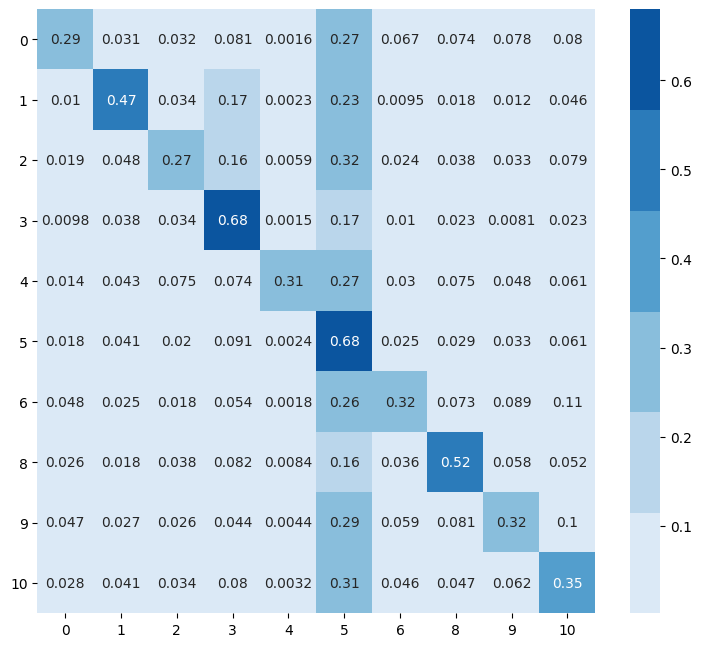

In [ ]:
cm.plot(y_true=y_dev_txt, y_pred=y_pred_txt, labels=label_list, normalize=True, figsize=(9, 8), dpi=100)
